In [ ]:
!pip install langgraph
!pip install langchain_groq
!pip install langchain_community

In [13]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

memory = MemorySaver()

import os

os.environ["TAVILY_API_KEY"] = ""

os.environ["GROQ_API_KEY"] = ""

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict):
    messages: Annotated[List, add_messages]

def model(state: BasicState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState):
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and
    len(last_message.tool_calls) > 0):
        return "tools"
    else:
        return END


graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

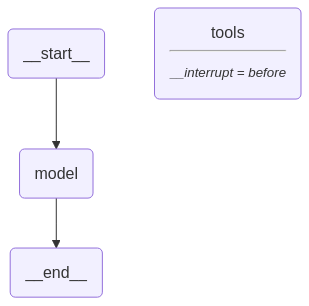

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [16]:

config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="Who is primeMinister of Nepal?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is primeMinister of Nepal?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ny8r)
 Call ID: call_ny8r
  Args:
    query: Nepal prime Minister


# Approve Section

In [17]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

# Again To LLM

In [18]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ny8r)
 Call ID: call_ny8r
  Args:
    query: Nepal prime Minister
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Prime Minister of Nepal - Wikipedia", "url": "https://en.wikipedia.org/wiki/Prime_Minister_of_Nepal", "content": "Jump to content\nMain menu\nSearch\nDonate\nCreate account\nLog in\nPersonal tools\nToggle the table of contents\nPrime Minister of Nepal\n17 languages\nArticle\nTalk\nRead\nEdit\nView history\nTools\nFrom Wikipedia, the free encyclopedia\nFor list of prime ministers, see List of prime ministers of Nepal.\nPrime Minister of the Federal Democratic Republic of Nepal\nनेपालको प्रधानमन्त्री\nEmblem of Nepal\nFlag of Nepal\nIncumbent\nK. P. Sharma Oli\nsince 15 July 2024[1]\nStyle   The Right Honourable [...] The residence of the prime minister is in Baluwatar, Ka